#  Обучаем Word2Wec

## Подготовка dataset-а

In [1]:
import numpy as np
import pandas as pd


train = pd.read_parquet('data_fusion_train.parquet', engine='pyarrow')
train = train[train.category_id == -1].drop_duplicates('item_name')


In [2]:
product_names = train['item_name']

In [3]:
import pymorphy2
import re
from pymorphy2 import MorphAnalyzer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


patterns = "[A-Za-z0-9!#$%&№'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

[nltk_data] Downloading package stopwords to /home/web/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обрабатываем 1/10 от всех данных

In [4]:
from tqdm import tqdm

result = []
num_iters = int(len(product_names)/1000)
last_iter = 0


for i in tqdm(range(num_iters)):
    i+=1
    if i == num_iters:
        result+=product_names[num_iters*1000:].apply(lemmatize).tolist()
    else:
        result+=product_names[last_iter*1000:i*1000].apply(lemmatize).tolist()
    last_iter += 1

100%|██████████| 3107/3107 [1:13:02<00:00,  1.41s/it]


In [7]:
data = [[_ for _ in ws if len(_) > 2] for ws in result if ws is not None]

In [8]:
from collections import defaultdict

word_freq = defaultdict(int)
for tokens in data:
    for token in tokens:
        word_freq[token] += 1

In [9]:
len(word_freq)

150971

In [10]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['далее',
 'смотреть',
 'таб',
 'пиво',
 'вес',
 'белый',
 'печение',
 'напиток',
 'салат',
 'сыр']

## Обучение

In [11]:
from gensim.models import Word2Vec


w2v_model = Word2Vec(
    min_count=10,
    window=2,
    size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

In [12]:
w2v_model.build_vocab(data)

In [13]:
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(180207208, 284221530)

In [14]:
w2v_model.init_sims(replace=True)

In [15]:
w2v_model.wv.most_similar(positive=["хлеб"])

[('полезновый', 0.6259607672691345),
 ('новосафоновский', 0.6063677072525024),
 ('рж\\пш', 0.6047245264053345),
 ('подовый', 0.5926578044891357),
 ('хлебушек', 0.5896375179290771),
 ('лкхк', 0.5894790887832642),
 ('тагарский', 0.5893803834915161),
 ('мухутдинов', 0.5892766714096069),
 ('гхлеб', 0.587183952331543),
 ('шипуновский', 0.5851653218269348)]

## Проверка качества модели

In [16]:
test = pd.read_parquet('data_fusion_train.parquet', engine='pyarrow')


In [17]:
test = test[test.category_id != -1].drop_duplicates('item_name')

In [18]:
test

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1,11,6,20:34,"Молоко 3,2%,шт",2.000,8,2,78,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.000,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.000,4,1,71,None
17,56,5,11:42,Кофе Капучино Большой Эден 18,1.000,12,1,70,None
40,105,3,01:53,Хлеб на СЫВОРОТКЕ 350г,1.000,7,-1,84,None
...,...,...,...,...,...,...,...,...,...
45669181,9880594,2,20:11,"Напиток Энерг. Ред Булл 0,355л",1.000,10,6,83,None
45681543,9908635,5,01:09,Хеменгуэй Дайкири,1.000,15,6,0,None
45690702,9929539,0,14:39,"Пиво светлое ""Халзан"" 4,5 % об, пл/б. 1,5 л(шт)",1.000,10,6,0,None
45692298,9932986,3,22:26,Экспресс педикюр,1.000,15,6,42,None


In [19]:
product_names = test['item_name']

In [20]:
product_names

1                                              Молоко 3,2%,шт
3                                   Компот из изюма, 114 ккал
4           Макаронные изделия отварные (масло сливочное),...
17                              Кофе Капучино Большой Эден 18
40                                     Хлеб на СЫВОРОТКЕ 350г
                                  ...                        
45669181                       Напиток Энерг. Ред Булл 0,355л
45681543                                    Хеменгуэй Дайкири
45690702      Пиво светлое "Халзан" 4,5 % об, пл/б. 1,5 л(шт)
45692298                                     Экспресс педикюр
45700308                 Конфеты Харитоша 1кг мол. ваф Яшкино
Name: item_name, Length: 48225, dtype: object

In [21]:
test_words = product_names.apply(lemmatize).tolist()

In [22]:
words_arrs = [[_ for _ in ws if len(_) > 2] if ws is not None else [] for ws in test_words]


In [23]:
embendding_len = len(w2v_model.wv.word_vec("хлеб"))
embendding_len

300

In [24]:
test_embenddings = []
for words in words_arrs:
    element_embenddings = []
    for word in words:
        try:
            element_embenddings.append(w2v_model.wv.word_vec(word))
        except KeyError:
            pass
    if len(element_embenddings) == 0:
        test_embenddings.append([0]*embendding_len)
    else:
        test_embenddings.append(sum(element_embenddings))
        
        

In [25]:
len(test_embenddings)

48225

In [26]:
len(words_arrs)

48225

In [27]:
data = test_embenddings
labels = test["category_id"].tolist()
print(len(data))
print(len(labels))

48225
48225


In [28]:
from sklearn.neighbors import KNeighborsClassifier


classifier = KNeighborsClassifier()
classifier.fit(data, labels)

KNeighborsClassifier()

## Оценка качества

In [29]:
from sklearn.metrics import classification_report
report = classification_report(classifier.predict(data), labels)


/home/web/workspace/kaggle/check_recognizer/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/web/workspace/kaggle/check_recognizer/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/web/workspace/kaggle/check_recognizer/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [30]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2118
           1       0.57      0.70      0.63        23
           2       0.72      0.90      0.80       254
           3       0.57      0.86      0.69        72
           4       0.52      0.67      0.59       175
           6       0.47      0.43      0.45        70
           7       0.62      0.70      0.65       198
           9       0.28      0.71      0.40        41
          11       0.49      0.72      0.58        32
          12       0.55      0.60      0.57       168
          13       0.27      0.83      0.41        12
          19       0.58      0.56      0.57        77
          20       0.58      0.85      0.69        40
          24       0.51      0.78      0.62        45
          26       0.14      0.38      0.20         8
          27       0.63      0.80      0.71        30
          29       0.78      0.68      0.73       149
          30       0.71    

## Визуализация

In [31]:
from sklearn import manifold

tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(data)

In [32]:
from matplotlib import pyplot as PLT
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/web/workspace/kaggle/check_recognizer/venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


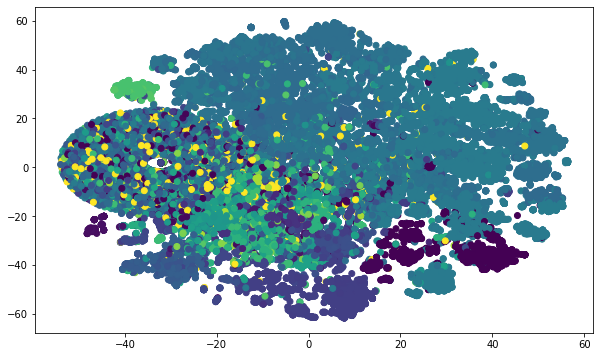

In [33]:
pylab.figure(figsize = (10, 6))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = labels)

## Количество нулевых векторов

In [34]:
count = 0
for embendding in tqdm(data):
    if np.array_equal(embendding, [0]*300):
        count += 1


100%|██████████| 48225/48225 [00:02<00:00, 19419.50it/s]


In [35]:
print(count*100/len(data), "% элементов выборки не обрабатываются моделью", sep='')

20.460342146189735% элементов выборки не обрабатываются моделью


## Примеры необрабатываемых объектов

In [36]:
count = 0

for embendding, words_arr, product_name in zip(data, words_arrs, product_names.tolist()):
    if np.array_equal(embendding, [0]*300):
        print(product_name)
#         print(words_arr)
        count += 1
    if count >= 20:
        break

Молоко 3,2%,шт
Пакет
Курник 1 шт.
Баклажаны 1кг
СМЕТАНА 20% 300Г
ЧИПСЫ КАРТОФЕЛЬНЫЕ
МОРС 200  мл
ЯБЛОКИ АЙДАРЕД
ГРУША КОНФЕРЕНЦИЯ
КРЕКЕР 100Г
400МЛ MRRICCO ORGANIC П/Я67%ДП
Картофель по-деревенски
Салат "Греческий"
Товар 1
Товар 5
Лимон Вес..
Кисель, 128 ккал
НАПИТОК PEPSI 0,33Л
Доставка
Яблоки


## Нужно обучать на всей выборке